c:\Users\Lenovo\Desktop\Retail_Store\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


✅ Data Loaded. Shape: (421570, 31)
Analyzing Store 1, Department 92 (Highest Volume)
📉 Preparing data for Store 1, Dept 92...


,Store,Dept,ds,y,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,Is_SuperBowl,Is_LaborDay,Is_Thanksgiving,Is_Christmas,Total_MarkDown,Type_Encoded,Lag_1,Lag_52,Rolling_Mean_4,Rolling_Std_4
9227,1,92,2010-02-05,139884.94,0,A,151315,42.31,2.572,0.0,...,0,0,0,0,0.0,3,0.00,0.0,0.0000,0.000000
9228,1,92,2010-02-12,143081.42,1,A,151315,38.51,2.548,0.0,...,1,0,0,0,0.0,3,139884.94,0.0,0.0000,0.000000
9229,1,92,2010-02-19,135066.75,0,A,151315,39.93,2.514,0.0,...,0,0,0,0,0.0,3,143081.42,0.0,0.0000,0.000000
9230,1,92,2010-02-26,125048.08,0,A,151315,46.63,2.561,0.0,...,0,0,0,0,0.0,3,135066.75,0.0,135770.2975,7870.699298
9231,1,92,2010-03-05,132945.44,0,A,151315,46.50,2.625,0.0,...,0,0,0,0,0.0,3,125048.08,0.0,134035.4225,7412.918774


Train Size: 117 weeks
Test Size:  26 weeks
🧠 Training Prophet Model...


10:15:50 - cmdstanpy - INFO - Chain [1] start processing
10:15:50 - cmdstanpy - INFO - Chain [1] done processing


   Adding regressors: ['CPI', 'Unemployment', 'Fuel_Price', 'IsHoliday']
🔮 Forecasting 26 weeks ahead...


c:\Users\Lenovo\Desktop\Retail_Store\src\forecasting.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future = future.fillna(method='bfill').fillna(0)


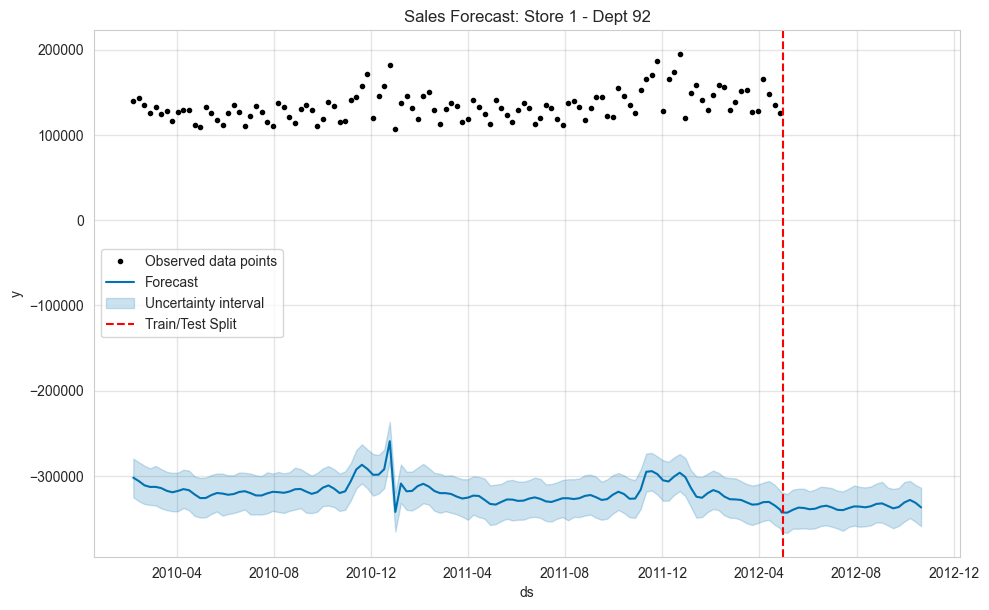

⚠️ Warning: No overlapping dates found between Forecast and Test Data.


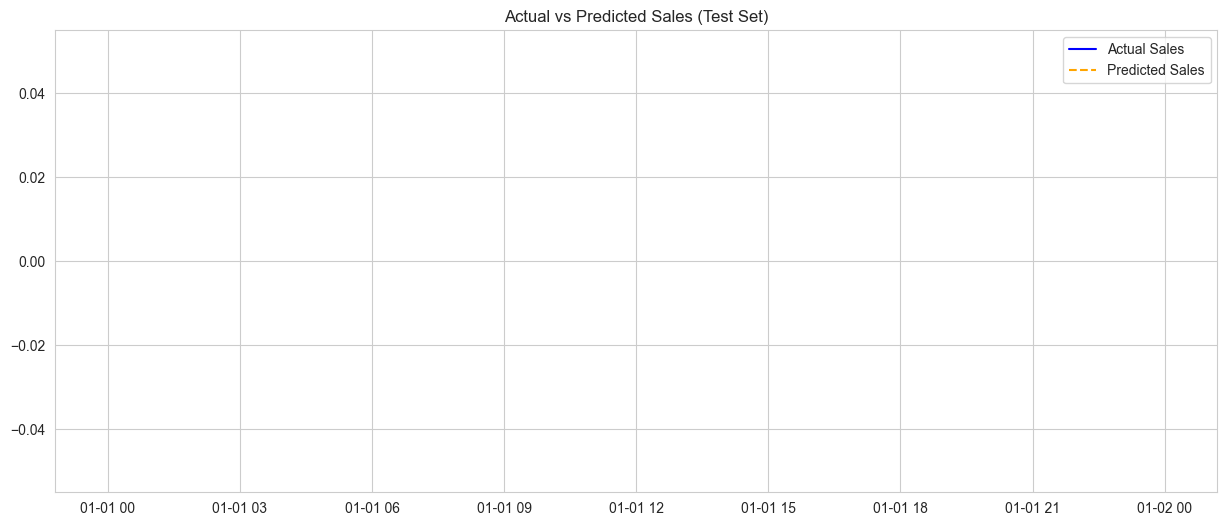

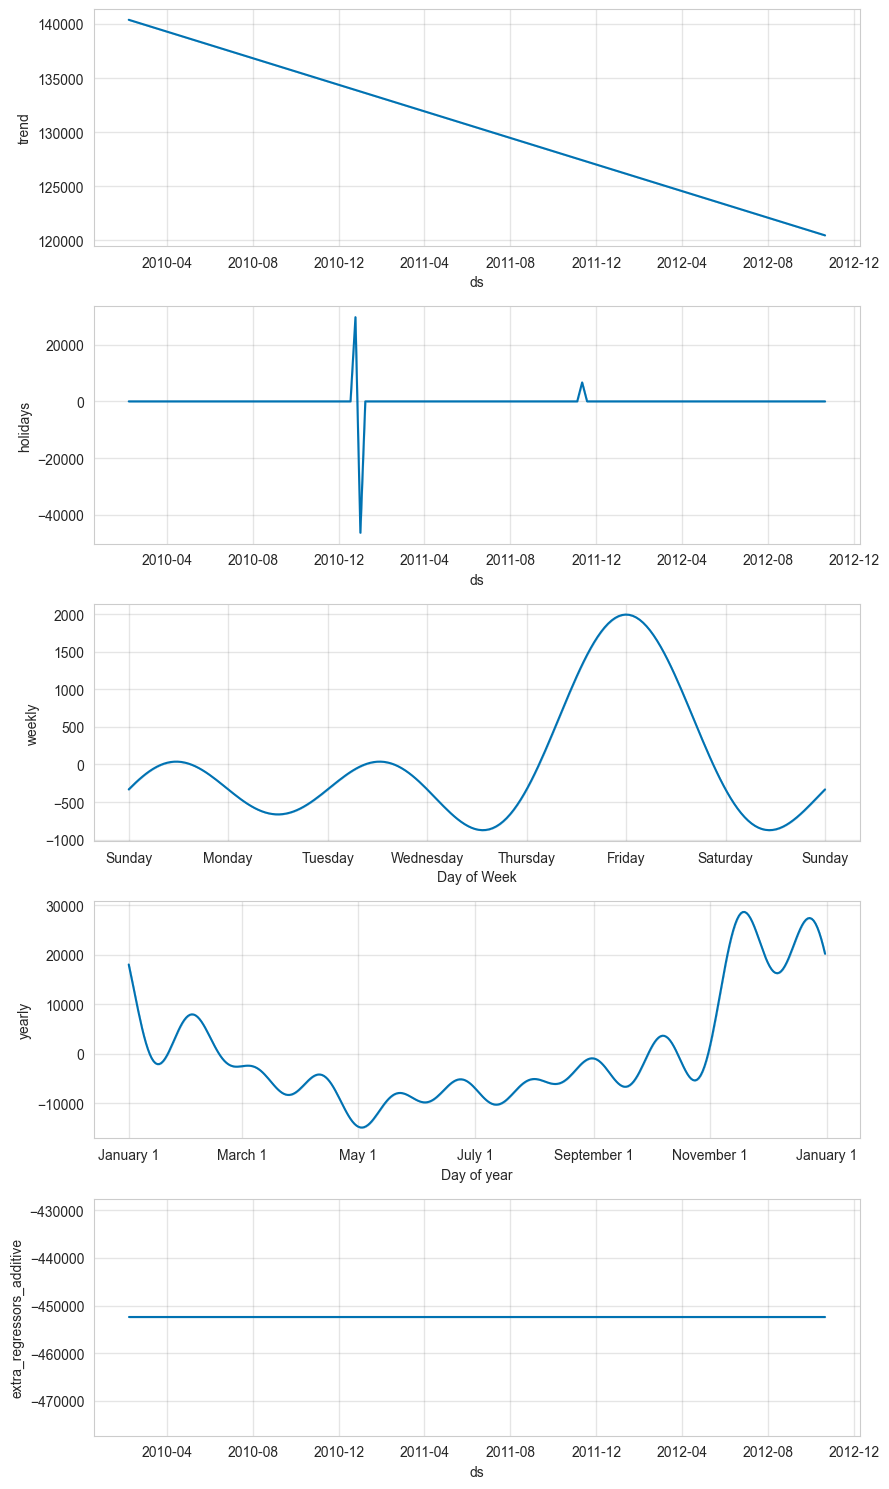

In [1]:
# %% [markdown]
# # 📈 Step 7: Demand Forecasting
# **Project:** Integrated Retail Analytics
#
# **Objective:**
# To predict Weekly Sales for specific Store-Department combinations.
#
# **Method:**
# We use **Facebook Prophet**, a robust additive regression model that handles:
# 1. **Seasonality:** Yearly and Weekly trends.
# 2. **Holidays:** Identifying spikes during Super Bowl, Christmas, etc.
# 3. **External Regressors:** Incorporating CPI, Fuel Price, and Unemployment.

# %% [markdown]
# ## 1. Setup & Data Loading

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add src to path
sys.path.append(os.path.abspath('..'))
from src.forecasting import RetailForecaster

# Set visual style
sns.set_style("whitegrid")

# Load Feature Engineered Data
data_path = "../data/processed/model_ready_data.csv"

if not os.path.exists(data_path):
    print("❌ Error: Data not found. Run Feature Engineering first.")
else:
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    print(f"✅ Data Loaded. Shape: {df.shape}")

# %% [markdown]
# ## 2. Select Target for Forecasting
# Forecasting 45 Stores * 80 Depts = 3600 models.
# For this demonstration, we will pick the **Top Performing Department** in **Store 1**.

# %%
# Identify biggest department in Store 1
top_dept = df[df['Store'] == 1].groupby('Dept')['Weekly_Sales'].sum().idxmax()
print(f"Analyzing Store 1, Department {top_dept} (Highest Volume)")

# Initialize Forecaster
forecaster = RetailForecaster(df)

# Prepare Data
store_id = 1
dept_id = top_dept
subset = forecaster.prepare_data(store_id, dept_id)

display(subset.head())

# %% [markdown]
# ## 3. Train/Test Split
# Time-series data must be split chronologically. We'll use the last 6 months as the Test set.

# %%
split_date = '2012-05-01'

train_df = subset[subset['ds'] < split_date]
test_df = subset[subset['ds'] >= split_date]

print(f"Train Size: {len(train_df)} weeks")
print(f"Test Size:  {len(test_df)} weeks")

# %% [markdown]
# ## 4. Train Model with External Regressors
# We will include economic indicators to help the model learn the impact of the economy on sales.

# %%
# Define external factors available in our data
regressors = ['CPI', 'Unemployment', 'Fuel_Price', 'IsHoliday']

# Train
model = forecaster.train_model(train_df, regressors=regressors)

# %% [markdown]
# ## 5. Predict
# We need to pass the "future" values of our regressors. 
# Since we have the actual test data, we will use the `test_df` to provide these values for evaluation purposes.

# %%
# We create a dataframe for the future that includes the dates + regressor columns
future_regressors = test_df[['ds'] + regressors]

# Forecast
forecast = forecaster.predict(periods=len(test_df), future_regressors_df=future_regressors)

# Visualize Forecast
fig = model.plot(forecast)
plt.title(f"Sales Forecast: Store {store_id} - Dept {dept_id}")
plt.axvline(pd.to_datetime(split_date), color='r', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()

# %% [markdown]
# ## 6. Evaluation
# How well did it perform against the unseen Test data?

# %%
rmse, mae, comparison = forecaster.evaluate(test_df)

# Plot Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(comparison['ds'], comparison['y'], label='Actual Sales', color='blue')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted Sales', color='orange', linestyle='--')
plt.title('Actual vs Predicted Sales (Test Set)')
plt.legend()
plt.show()

# %% [markdown]
# ## 7. Component Analysis
# This is powerful. It tells us the impact of holidays and general trend.

# %%
forecaster.plot_components()

# %% [markdown]
# **Component Insights:**
# * **Trend:** Is the store growing or shrinking long-term?
# * **Holidays:** Look at the specific spikes. Are they correctly capturing Christmas/Thanksgiving?
# * **Weekly:** (Less relevant here since data is weekly aggregated, but shows intra-year seasonality).